# 11. Linear Regression

## 11.7 Bayesian linear regression

### 11.7.3 Example

> Bayesian inference for simple linear regression with known noise variance  
> The goal is to reproduce fig 3.7 from Bishop's book.  
> We fit the linear model f(x,w) = w0 + w1*x and plot the posterior over w.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
N = 100  # Number of (x,y) training points

# Because of how axises are set up, x and y values should be in the same range as the coefficients.
rng = np.random.default_rng()

X = rng.uniform(low=-1, high=1, size=N)
X = np.stack([np.ones_like(X), X], axis=-1)

# True regression parameters that we wish to recover. Do not set these outside the range of [-1,1]
w = np.array([-0.3, 0.5])
σ = 0.2  # True noise standard deviation
y = np.dot(X, w) + rng.normal(loc=0, scale=σ, size=N)

X.shape, y.shape

((100, 2), (100,))

In [16]:
σ2 = σ * σ # The likelihood variance, p(y|X,w,σ^2) = N(y|Xw,σ^2I)
τ2 = 1 / 2 # The prior variance, p(w) = N(w|0, τ^2I)

# Given data vectors X and y, this returns the posterior mean and covariance.
def ridge_posterior_mean_cov(X, y, σ2=1, τ2=1):
    precision = np.diag(np.full(X.shape[1], 1 / τ2)) + (1 / σ2) * X.T @ X
    cov = np.linalg.inv(precision)
    mean = (1 / σ2) * cov @ X.T @ y
    return mean, cov

ridge_posterior_mean_cov(X, y, σ2, τ2)

(array([-0.33271522,  0.43111117]),
 array([[3.99769382e-04, 1.07435531e-05],
        [1.07435531e-05, 1.29505751e-03]]))

In [17]:
from scipy.stats import norm, multivariate_normal

# For a given (x, y) pair, this returns a vectorized likelihood function.
def vectorized_likelihood(X, y, σ2=1):
    def out(w0, w1):
        return norm.pdf(y, loc=np.dot(X, (w0, w1)), scale=np.sqrt(σ2))
    return np.vectorize(out)

# For a given (mean, cov) pair, this returns a vectorized pdf function.
def vectorized_mvn(mean=(0, 0), cov=np.identity(2)):
    def out(w0, w1):
        return multivariate_normal.pdf((w0, w1), mean=mean, cov=cov)
    return np.vectorize(out)

vectorized_likelihood((1, 0), 0, σ2)(0, 0), vectorized_mvn()(0, 0)

(array(1.9947114), array(0.15915494))

#### Figure 11.20: Sequential Bayesian inference of the parameters of a linear regression model.

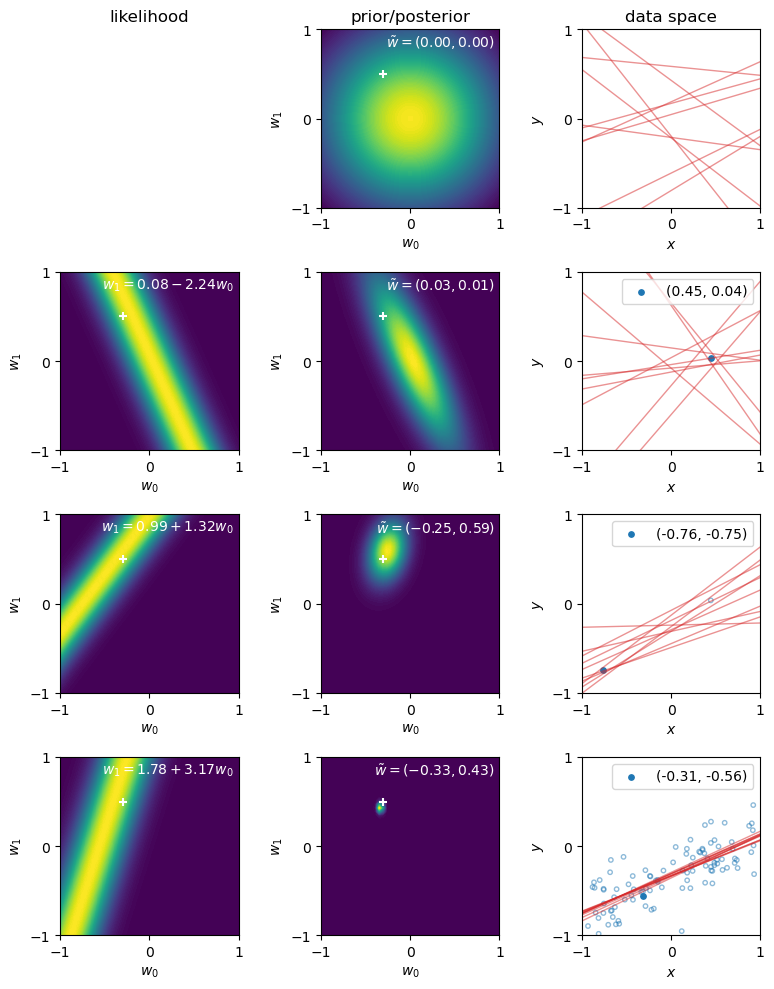

In [18]:
n_sample_lines = 10

# Grid space for which values will be determined, which is shared between the coefficient space and data space.
grid = np.linspace(-1, 1, 50)
xx, yy = np.meshgrid(grid, grid)

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(8, 10))

for ax in axes.ravel():
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal')
# 1st and 2nd columns
for ax in axes[:, :-1].ravel():
    ax.set_xlabel('$w_0$')
    ax.set_ylabel('$w_1$')
# 3rd column
for ax in axes[:, -1]:
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

# This builds the graph one row at a time.
for i, ind in enumerate([0, 1, 2, 100]):
    # Left graph (likelihood)
    if ind == 0:
        axes[0, 0].axis('off')
        post_mean = np.array((0, 0)) # prior mean
        post_cov = np.diag((τ2, τ2)) # prior covariance
    else:
        likelihood_ftn = vectorized_likelihood(X[ind-1], y[ind-1], σ2)
        axes[i, 0].contourf(xx, yy, likelihood_ftn(xx, yy), levels=100)
        axes[i, 0].scatter(*w, s=30, marker='+', color='white')
        axes[i, 0].text(.95, .95, f'$w_1={y[ind-1] / X[ind-1, 1]:.2f}{-1 / X[ind-1, 1]:+.2f}w_0$', color='white', ha='right', va='top')
        post_mean, post_cov = ridge_posterior_mean_cov(X[:ind], y[:ind], σ2, τ2)

    # Middle graph (prior/posterior)
    posterior_ftn = vectorized_mvn(post_mean, post_cov)
    axes[i, 1].contourf(xx, yy, posterior_ftn(xx, yy), levels=100)
    axes[i, 1].scatter(*w, s=30, marker='+', color='white')
    axes[i, 1].text(.95, .95, f'$\\tilde w=({post_mean[0]:.2f}, {post_mean[1]:.2f})$', color='white', ha='right', va='top')

    # Right graph (data space)
    samples = rng.multivariate_normal(post_mean, post_cov, size=n_sample_lines)
    lines = np.stack([np.ones_like(grid), grid], axis=-1) @ samples.T
    for l in lines.T:
        axes[i, 2].plot(grid, l, color='tab:red', lw=1, alpha=0.5)
    if ind != 0:
        axes[i, 2].scatter(X[:ind-1, 1], y[:ind-1], s=10, facecolors='none', edgecolors='tab:blue', alpha=0.5)
        axes[i, 2].scatter(X[ind-1, 1], y[ind-1], s=15, color='tab:blue', label=f'({X[ind-1, 1]:.2f}, {y[ind-1]:.2f})')
        axes[i, 2].legend(loc='upper right')

axes[0, 0].set_title('likelihood')
axes[0, 1].set_title('prior/posterior')
axes[0, 2].set_title('data space')

fig.tight_layout()